In [98]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import random
import numpy as np
import pandas as pd
from sklearn.utils import Bunch
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
class MLP:
    def __init__(
        self,
        num_entrada,
        num_neuronio_oculto,
        num_classe,
        taxa_aprendizado=0.1,
        epocas=1000,
    ):
        self.num_entrada = num_entrada
        self.num_neuronio_oculto = num_neuronio_oculto
        self.num_classe = num_classe
        self.taxa_aprendizado = taxa_aprendizado
        self.epocas = epocas

        self.pesos_ocultos = np.random.uniform(
            0, 0.1, (num_entrada, num_neuronio_oculto))
        self.bias_oculto = np.zeros((1, num_neuronio_oculto))
        self.pesos_saida = np.random.uniform(
            0, 0.1, (num_neuronio_oculto, num_classe))
        self.bias_saida = np.zeros((1, num_classe))
        print(
            "num_entrada: ",
            self.num_entrada,
            "num_neuronio_oculto: ",
            self.num_neuronio_oculto,
            "num_classe: ",
            self.num_classe,
            "taxa_aprendizado: ",
            self.taxa_aprendizado,
            "epocas: ",
            self.epocas,
        )
        # print("\npesos_ocultos:\n ", self.pesos_ocultos, "\nbias_oculto:\n ", self.bias_oculto,
        #      "\npesos_saida:\n ", self.pesos_saida, "\nbias_saida:\n ", self.bias_saida)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        ativacao_oculta = np.dot(X, self.pesos_ocultos)
        ativacao_oculta += self.bias_oculto
        saida_oculta = self.sigmoid(ativacao_oculta)

        ativacao_saida = np.dot(saida_oculta, self.pesos_saida)
        ativacao_saida += self.bias_saida
        saida = self.sigmoid(ativacao_saida)

        return saida_oculta, saida

    def backward(self, X, y, saida_oculta, saida):
        # print("saida_oculta: ",saida_oculta)
        erro_saida = y - saida
        delta_saida = erro_saida * (saida * (1 - saida) + 0.05)
        # print("delta_saida: ",delta_saida)

        erro_oculto = np.dot(delta_saida, self.pesos_saida.T)
        delta_oculto = erro_oculto * (saida_oculta * (1 - saida_oculta) + 0.05)

        self.pesos_saida += np.dot(saida_oculta.T,
                                   delta_saida) * self.taxa_aprendizado
        self.bias_saida += (
            np.sum(delta_saida, axis=0, keepdims=True) * self.taxa_aprendizado
        )

        self.pesos_ocultos += np.dot(X.T, delta_oculto) * self.taxa_aprendizado
        self.bias_oculto += (
            np.sum(delta_oculto, axis=0, keepdims=True) * self.taxa_aprendizado
        )

    def treinar(self, X, y):
        self.pesos_ocultos = np.random.randn(
            self.num_entrada, self.num_neuronio_oculto)
        self.bias_oculto = np.zeros((1, self.num_neuronio_oculto))
        self.pesos_saida = np.random.randn(
            self.num_neuronio_oculto, self.num_classe)
        self.bias_saida = np.zeros((1, self.num_classe))
        for i in range(self.epocas):
            saida_oculta, saida = self.forward(X)
            self.backward(X, y, saida_oculta, saida)

    def testar(self, X, y):
        n_amostras = X.shape[0]
        erros_quadraticos = []
        matriz_confusao = None
        num_predicoes_corretas = 0

        saida_oculta, saida = self.forward(X)

        rotulos_previstos = np.argmax(saida, axis=1)
        rotulos_verdadeiros = np.argmax(y, axis=1)

        # calcular acurácia e erro médio quadrático
        for i in range(n_amostras):
            erros_quadraticos.append(
                sum(
                    [
                        (y[i][k] - (1 if k == rotulos_previstos[i] else 0)) ** 2
                        for k in range(self.num_classe)
                    ]
                )
            )
            if rotulos_previstos[i] == rotulos_verdadeiros[i]:
                num_predicoes_corretas += 1

        acuracia = num_predicoes_corretas / n_amostras
        std_acuracia = np.sqrt(acuracia * (1 - acuracia) / n_amostras)
        erro_medio_quadratico = np.mean(erros_quadraticos)

        # calcular matriz de confusão
        rotulos_classes = list(set(rotulos_verdadeiros))
        n_classes = len(rotulos_classes)
        matriz_confusao = [
            [0 for i in range(n_classes)] for j in range(n_classes)]

        for i in range(n_amostras):
            rotulo_previsto = rotulos_previstos[i]
            rotulo_verdadeiro = rotulos_classes.index(rotulos_verdadeiros[i])
            matriz_confusao[rotulo_verdadeiro][rotulo_previsto] += 1

        return acuracia, std_acuracia, matriz_confusao, erro_medio_quadratico

    def rodar_independentes(self, X, y, n_rodadas):
        acuracias_t = []
        std_acuracias_t = []
        matrizes_confusao_t = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos_t = []

        acuracias = []
        std_acuracias = []
        matrizes_confusao = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos = []

        for i in range(n_rodadas):
            # separa as amostra 80,20
            y_treino_one_hot = np.eye(self.num_classe)[y]

            X_treino, X_teste, y_treino, y_teste = train_test_split(
                X, y_treino_one_hot, test_size=0.2
            )
            # print("\n\n", y_teste[1])
            self.treinar(X_treino, y_treino)

            (
                acuracia_t,
                std_acuracia_t,
                matriz_confusao_t,
                erro_medio_quadratico_t,
            ) = self.testar(X_treino, y_treino)
            acuracias_t.append(acuracia_t)
            std_acuracias_t.append(std_acuracia_t)
            matrizes_confusao_t += matriz_confusao_t
            erros_quadraticos_t.append(erro_medio_quadratico_t)

            (
                acuracia,
                std_acuracia,
                matriz_confusao,
                erro_medio_quadratico,
            ) = self.testar(X_teste, y_teste)
            acuracias.append(acuracia)
            std_acuracias.append(std_acuracia)
            matrizes_confusao += matriz_confusao
            erros_quadraticos.append(erro_medio_quadratico)
        # print("bias_oculto: ",self.bias_oculto)
        return (
            acuracias,
            std_acuracias,
            matrizes_confusao,
            erros_quadraticos,
            acuracias_t,
            std_acuracias_t,
            matrizes_confusao_t,
            erros_quadraticos_t,
        )

In [100]:
# normaliza
def normaliza(datas):
    nomes_coluna = [
        coluna
        for coluna in datas.columns
        if coluna != "target" and coluna != "classe" and coluna != "bias"
    ]
    for coluna in nomes_coluna:
        min_value = datas[coluna].min()
        max_value = datas[coluna].max()
        datas[coluna] = (datas[coluna] - min_value) / (max_value - min_value)
    return pd.DataFrame(datas)

In [101]:
# coluna
coluna = pd.read_csv("Coluna/column_3C_weka.arff", header=None, sep=",")
coluna.columns = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis",
    "target",
]
coluna["target"].replace(to_replace="Hernia", value=0, inplace=True)
coluna["target"].replace(to_replace="Spondylolisthesis", value=1, inplace=True)
coluna["target"].replace(to_replace="Normal", value=2, inplace=True)
coluna2 = pd.DataFrame(coluna)
coluna = normaliza(coluna)
X1 = coluna.drop(["target"], axis=1)
y1 = coluna["target"]
# print(X1)
# print(y1)
# criar instância da classe MLP2 e treinar/testar com 10 rodadas independentes

num_entrada:  6 num_neuronio_oculto:  5 num_classe:  3 taxa_aprendizado:  0.05 epocas:  2000

----------------treino-----------------

Acurácia = 87.47%, Erro Médio Quadrático = 0.25 , DP: 2.10%
[[1789.   30.  581.]
 [  48. 5796.  153.]
 [ 593.  149. 3261.]]

-----------------teste---------------

Acurácia = 85.48%, Erro Médio Quadrático = 0.29 , DP: 4.43%
[[ 402.   19.  179.]
 [  19. 1438.   46.]
 [ 149.   38.  810.]]


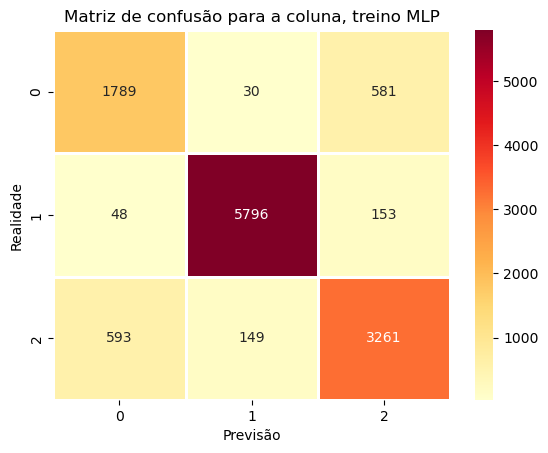

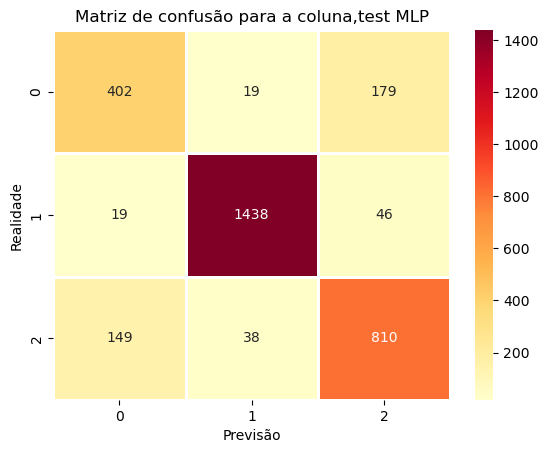

In [102]:
mlp2 = MLP(
    num_entrada=6,
    num_neuronio_oculto=5,
    num_classe=3,
    taxa_aprendizado=0.05,
    epocas=2000,
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = mlp2.rodar_independentes(X1, y1, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(matrizes_confusao)

# 0 = Hernia  1= Spondylolisthesis 2= Normal
sns.heatmap(matrizes_confusao_t, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna, treino MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna,test MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

In [103]:
# Torneamento
Torneamento = pd.read_excel(
    'Torneamento/dados_torneamento.xlsx', sheet_name='166')
Torneamento = normaliza(Torneamento)
Torneamento['classe'] = Torneamento['classe'] - 1
# Exibir os dados
X2 = Torneamento.drop(["classe"], axis=1)
y2 = Torneamento["classe"]

num_entrada:  9 num_neuronio_oculto:  20 num_classe:  5 taxa_aprendizado:  0.1 epocas:  2000

----------------treino-----------------

Acurácia = 70.61%, Erro Médio Quadrático = 0.59 , DP: 2.90%
[[2034.  240.   30.    6.  109.]
 [ 389. 1885.   56.   11.   83.]
 [ 132.  150. 1203.  637.  265.]
 [  97.    4.  450. 1617.  214.]
 [ 112.   62.  158.  322. 1734.]]

-----------------teste---------------

Acurácia = 59.20%, Erro Médio Quadrático = 0.82 , DP: 6.26%
[[444.  81.  14.  11.  31.]
 [117. 376.  33.   5.  45.]
 [ 42.  55. 228. 210.  78.]
 [ 39.   5. 154. 340.  80.]
 [ 44.  41.  55.  84. 388.]]


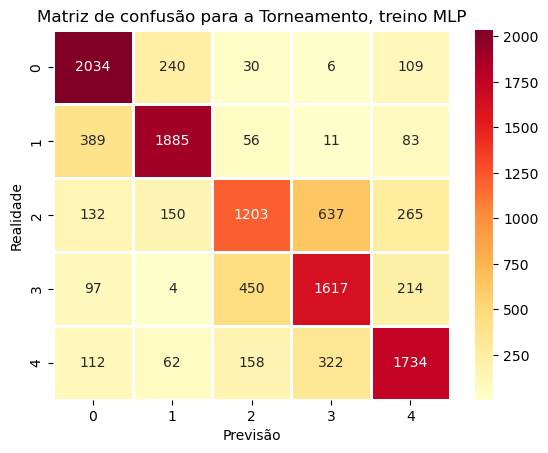

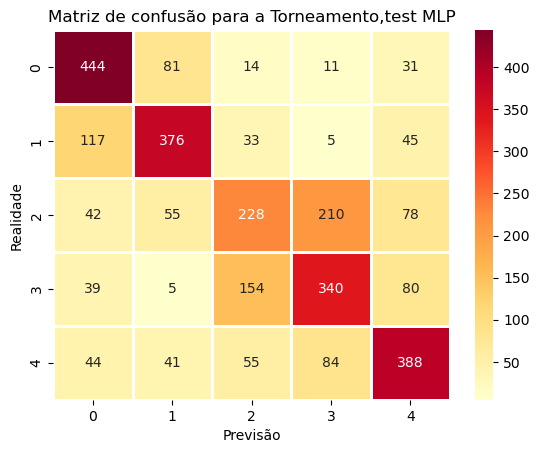

In [104]:
mlp3 = MLP(
    num_entrada=9,
    num_neuronio_oculto=20,
    num_classe=5,
    taxa_aprendizado=0.1,
    epocas=2000,
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = mlp3.rodar_independentes(X2, y2, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(matrizes_confusao)

# 0 = Hernia  1= Spondylolisthesis 2= Normal
sns.heatmap(matrizes_confusao_t, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a Torneamento, treino MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a Torneamento,test MLP")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

In [105]:
class ELM:
    def __init__(
        self,
        num_entrada,
        num_neuronio_oculto,
        num_classe,
    ):
        self.num_entrada = num_entrada
        self.num_neuronio_oculto = num_neuronio_oculto
        self.num_classe = num_classe

        self.pesos_ocultos = np.random.uniform(
            0, 0.1, (num_entrada, num_neuronio_oculto))
        self.bias_oculto = np.zeros((1, num_neuronio_oculto))
        self.pesos_saida = np.random.uniform(
            0, 0.1, (num_neuronio_oculto, num_classe))
        self.bias_saida = np.zeros((1, num_classe))
        print(
            "num_entrada: ",
            self.num_entrada,
            "num_neuronio_oculto: ",
            self.num_neuronio_oculto,
            "num_classe: ",
            self.num_classe
        )
        # print("\npesos_ocultos:\n ", self.pesos_ocultos, "\nbias_oculto:\n ", self.bias_oculto,
        #      "\npesos_saida:\n ", self.pesos_saida, "\nbias_saida:\n ", self.bias_saida)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        ativacao_oculta = np.dot(X, self.pesos_ocultos)
        ativacao_oculta += self.bias_oculto
        saida_oculta = self.sigmoid(ativacao_oculta)

        ativacao_saida = np.dot(saida_oculta, self.pesos_saida)
        ativacao_saida += self.bias_saida
        saida = self.sigmoid(ativacao_saida)

        return saida_oculta, saida

    def backward(self, X, Y, saida_oculta):
        # Calcular a pseudoinversa de H
        H_pinv = np.linalg.pinv(saida_oculta)

        # Calcular os pesos da camada de saída beta
        self.pesos_saida = np.dot(H_pinv, Y)

    def treinar(self, X, y):
        self.pesos_ocultos = np.random.randn(
            self.num_entrada, self.num_neuronio_oculto)
        self.bias_oculto = np.zeros((1, self.num_neuronio_oculto))
        self.pesos_saida = np.random.randn(
            self.num_neuronio_oculto, self.num_classe)
        self.bias_saida = np.zeros((1, self.num_classe))

        saida_oculta, saida = self.forward(X)
        self.backward(X, y, saida_oculta)

    def testar(self, X, y):
        n_amostras = X.shape[0]
        erros_quadraticos = []
        matriz_confusao = None
        num_predicoes_corretas = 0

        saida_oculta, saida = self.forward(X)

        rotulos_previstos = np.argmax(saida, axis=1)
        rotulos_verdadeiros = np.argmax(y, axis=1)

        # calcular acurácia e erro médio quadrático
        for i in range(n_amostras):
            erros_quadraticos.append(
                sum(
                    [
                        (y[i][k] - (1 if k == rotulos_previstos[i] else 0)) ** 2
                        for k in range(self.num_classe)
                    ]
                )
            )
            if rotulos_previstos[i] == rotulos_verdadeiros[i]:
                num_predicoes_corretas += 1

        acuracia = num_predicoes_corretas / n_amostras
        std_acuracia = np.sqrt(acuracia * (1 - acuracia) / n_amostras)
        erro_medio_quadratico = np.mean(erros_quadraticos)

        # calcular matriz de confusão
        rotulos_classes = list(set(rotulos_verdadeiros))
        n_classes = len(rotulos_classes)
        matriz_confusao = [
            [0 for i in range(n_classes)] for j in range(n_classes)]

        for i in range(n_amostras):
            rotulo_previsto = rotulos_previstos[i]
            rotulo_verdadeiro = rotulos_classes.index(rotulos_verdadeiros[i])
            matriz_confusao[rotulo_verdadeiro][rotulo_previsto] += 1

        return acuracia, std_acuracia, matriz_confusao, erro_medio_quadratico

    def rodar_independentes(self, X, y, n_rodadas):
        acuracias_t = []
        std_acuracias_t = []
        matrizes_confusao_t = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos_t = []

        acuracias = []
        std_acuracias = []
        matrizes_confusao = np.zeros((self.num_classe, self.num_classe))
        erros_quadraticos = []

        for i in range(n_rodadas):
            # separa as amostra 80,20
            y_treino_one_hot = np.eye(self.num_classe)[y]

            X_treino, X_teste, y_treino, y_teste = train_test_split(
                X, y_treino_one_hot, test_size=0.2
            )
            # print("\n\n", y_teste[1])
            self.treinar(X_treino, y_treino)

            (
                acuracia_t,
                std_acuracia_t,
                matriz_confusao_t,
                erro_medio_quadratico_t,
            ) = self.testar(X_treino, y_treino)
            acuracias_t.append(acuracia_t)
            std_acuracias_t.append(std_acuracia_t)
            matrizes_confusao_t += matriz_confusao_t
            erros_quadraticos_t.append(erro_medio_quadratico_t)

            (
                acuracia,
                std_acuracia,
                matriz_confusao,
                erro_medio_quadratico,
            ) = self.testar(X_teste, y_teste)
            acuracias.append(acuracia)
            std_acuracias.append(std_acuracia)
            matrizes_confusao += matriz_confusao
            erros_quadraticos.append(erro_medio_quadratico)
        # print("bias_oculto: ",self.bias_oculto)
        return (
            acuracias,
            std_acuracias,
            matrizes_confusao,
            erros_quadraticos,
            acuracias_t,
            std_acuracias_t,
            matrizes_confusao_t,
            erros_quadraticos_t,
        )

In [106]:
# coluna
coluna = pd.read_csv("Coluna/column_3C_weka.arff", header=None, sep=",")
coluna.columns = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis",
    "target",
]
coluna["target"].replace(to_replace="Hernia", value=0, inplace=True)
coluna["target"].replace(to_replace="Spondylolisthesis", value=1, inplace=True)
coluna["target"].replace(to_replace="Normal", value=2, inplace=True)
coluna2 = pd.DataFrame(coluna)
coluna = normaliza(coluna)
X3 = coluna.drop(["target"], axis=1)
y3 = coluna["target"]
# print(X1)
# print(y1)
# criar instância da classe MLP2 e treinar/testar com 10 rodadas independentes

num_entrada:  6 num_neuronio_oculto:  10 num_classe:  3

----------------treino-----------------

Acurácia = 83.85%, Erro Médio Quadrático = 0.32 , DP: 2.33%
[[1448.  103.  843.]
 [  72. 5628.  301.]
 [ 429.  254. 3322.]]

-----------------teste---------------

Acurácia = 82.16%, Erro Médio Quadrático = 0.36 , DP: 4.78%
[[ 357.   27.  222.]
 [  30. 1381.   88.]
 [ 123.   63.  809.]]


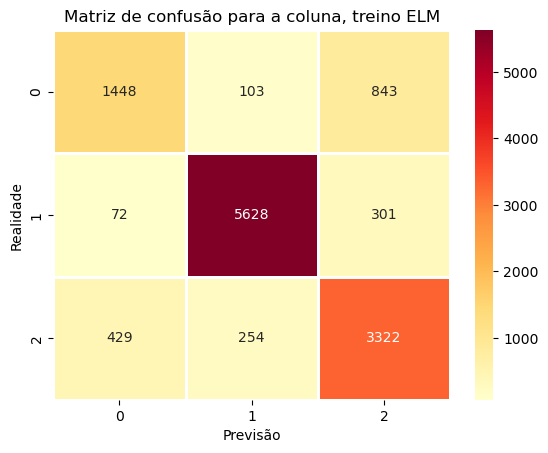

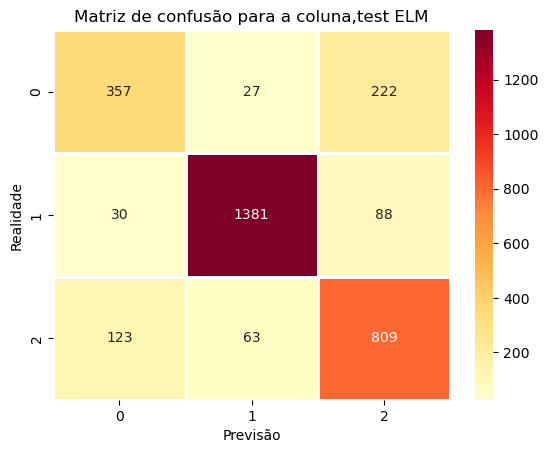

In [107]:
elm2 = ELM(
    num_entrada=6,
    num_neuronio_oculto=10,
    num_classe=3,
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = elm2.rodar_independentes(X1, y1, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(matrizes_confusao)

# 0 = Hernia  1= Spondylolisthesis 2= Normal
sns.heatmap(matrizes_confusao_t, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna, treino ELM")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a coluna,test ELM")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

In [108]:
# Torneamento
Torneamento = pd.read_excel(
    'Torneamento/dados_torneamento.xlsx', sheet_name='166')
Torneamento = normaliza(Torneamento)
Torneamento['classe'] = Torneamento['classe'] - 1
# Exibir os dados
X2 = Torneamento.drop(["classe"], axis=1)
y2 = Torneamento["classe"]

num_entrada:  9 num_neuronio_oculto:  20 num_classe:  5

----------------treino-----------------

Acurácia = 78.08%, Erro Médio Quadrático = 0.44 , DP: 2.66%
[[2.137e+03 2.090e+02 1.300e+01 4.800e+01 1.600e+01]
 [1.410e+02 2.037e+03 7.000e+00 2.000e+00 2.170e+02]
 [1.630e+02 8.400e+01 1.256e+03 6.550e+02 2.080e+02]
 [1.610e+02 1.000e+00 5.410e+02 1.629e+03 6.500e+01]
 [9.000e+00 3.500e+01 6.000e+00 5.000e+01 2.310e+03]]

-----------------teste---------------

Acurácia = 67.00%, Erro Médio Quadrático = 0.66 , DP: 6.01%
[[463.  82.   9.  17.   6.]
 [ 59. 448.   1.   2.  86.]
 [ 80.  28. 228. 234.  64.]
 [ 58.   1. 186. 332.  26.]
 [  7.  20.   1.  23. 539.]]


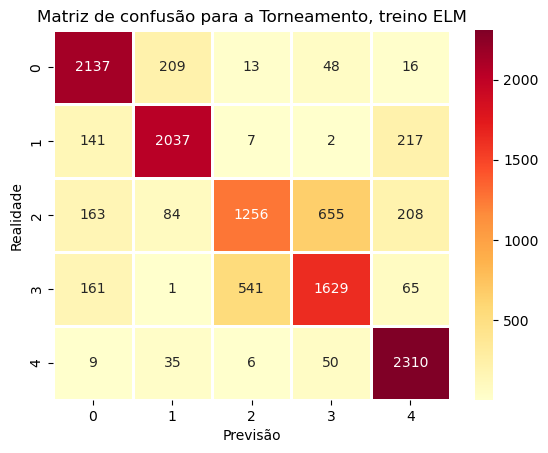

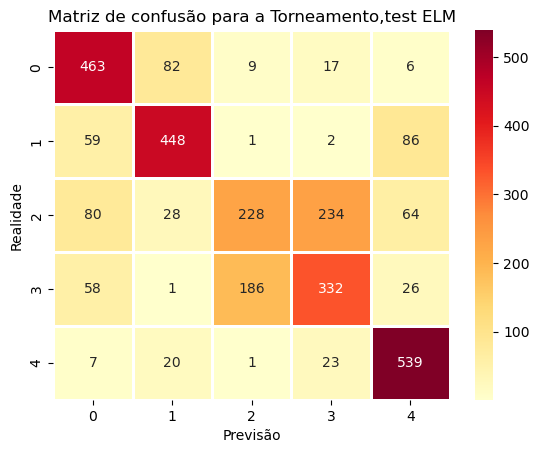

In [109]:
elm3 = ELM(
    num_entrada=9,
    num_neuronio_oculto=20,
    num_classe=5
)
(
    acuracias,
    std_acuracias,
    matrizes_confusao,
    erros_quadraticos,
    acuracias_t,
    std_acuracias_t,
    matrizes_confusao_t,
    erros_quadraticos_t,
) = elm3.rodar_independentes(X2, y2, n_rodadas=50)

# imprimir resultados das 10 rodadas
print("\n----------------treino-----------------\n")
# for i in range(len(acuracias_t)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias_t[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos_t[i]:.2f} , DP: {(std_acuracias_t[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias_t)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos_t):.2f} , DP: {(np.mean(std_acuracias_t)*100):.2f}%"
)
print(matrizes_confusao_t)

print("\n-----------------teste---------------\n")
# for i in range(len(acuracias)):
# print(f"Rodada {i+1}: Acurácia = {(acuracias[i]*100):.2f}%, Erro Médio Quadrático = {erros_quadraticos[i]:.2f} , DP: {(std_acuracias[i]*100):.2f}%")
print(
    f"Acurácia = {(np.mean(acuracias)*100):.2f}%, Erro Médio Quadrático = {np.mean(erros_quadraticos):.2f} , DP: {(np.mean(std_acuracias)*100):.2f}%"
)
print(matrizes_confusao)

# 0 = Hernia  1= Spondylolisthesis 2= Normal
sns.heatmap(matrizes_confusao_t, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a Torneamento, treino ELM")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()

sns.heatmap(matrizes_confusao, annot=True,
            cmap="YlOrRd", linewidths=1, fmt=".0f")
plt.title("Matriz de confusão para a Torneamento,test ELM")
plt.xlabel("Previsão")
plt.ylabel("Realidade")
plt.show()